In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import statsmodels
import datetime

# Aggregated data

In [2]:
data_df = pd.read_csv('korea_bars_per_month.csv')

In [3]:
data_df.shape

(2477624, 8)

In [4]:
data_df.bar_id.nunique()

104294

In [5]:
data_df.head()

bar_id  category_id  month  year  item_count  sales_before_tax  item_qty  \
0   18196          2.0     10  2018         892        13991100.0     946.0   
1   39807          4.0      3  2020         120          298287.0     169.0   
2   39993          2.0      3  2020        1144        50045418.0    2705.0   
3   40414          4.0      3  2020        6633        25428667.0    8140.0   
4   40656          2.0      3  2020        2586        42548926.0    5222.0   

   unique_item_count  
0                 43  
1                  1  
2                  6  
3                 72  
4                 17

In [41]:
data_df['date'] = pd.to_datetime(data_df.date)

In [6]:
#data_week_df = data_df.set_index('date')

In [7]:
#data_week_df = data_week_df.groupby(by=['bar_id', 'category_id']).sales.resample('W').sum().reset_index()

# Aggregate revenue per month

In [11]:
month_agg_df = data_df.groupby(by=['year', 'month', 'category_id']).agg({'sales_before_tax' : ['sum', 'mean'],                                                       
                                                       'bar_id' : 'count', 
                                                       'item_qty' : ['sum', 'mean'] }).reset_index()

In [12]:
month_agg_df.head()

year month category_id sales_before_tax               bar_id item_qty  \
                                       sum          mean  count      sum   
0  2002     1         1.0       21542400.0  4.308480e+06      5   4566.0   
1  2002     1         2.0      200965600.0  3.349427e+07      6  28670.0   
2  2002     1         3.0       32796900.0  6.559380e+06      5   7415.0   
3  2002     1         4.0        3931000.0  9.827500e+05      4   2049.0   
4  2002     1         5.0        4650300.0  2.325150e+06      2    900.0   

                
          mean  
0   913.200000  
1  4778.333333  
2  1483.000000  
3   512.250000  
4   450.000000

In [17]:
month_agg_df.columns = ["_".join(x) for x in month_agg_df.columns.ravel()]

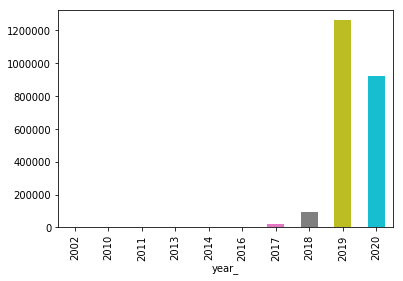

In [32]:
month_agg_df[month_agg_df.year_ > 2000].\
    groupby([month_agg_df.year_])['bar_id_count'].sum().plot(kind="bar")

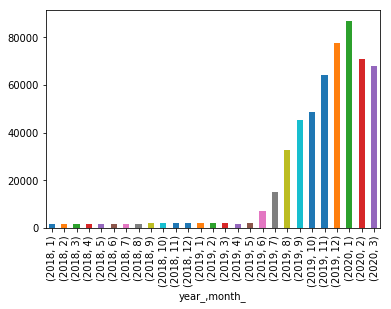

In [90]:
month_agg_df[month_agg_df.year_ > 2017].\
    groupby([month_agg_df.year_, month_agg_df.month_])['bar_id_count'].max().plot(kind="bar")

In [91]:
month_agg_df[(month_agg_df.year_ == 2020) & (month_agg_df.month_ == 3)].bar_id_count.max()

68023

1
2
3
4
5
6


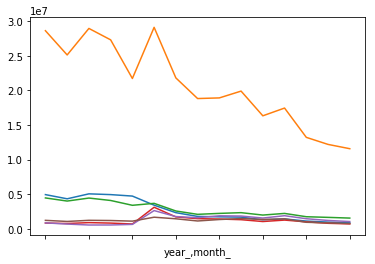

In [92]:
for cat_id in range(1,7):
    print(cat_id)
    month_agg_df[(month_agg_df.year_ > 2018) & (month_agg_df.category_id_ == cat_id)].\
        groupby([month_agg_df.year_, month_agg_df.month_])\
        ['sales_before_tax_mean'].sum().plot()

# Define churn bar

In [78]:
data_df['day'] = 1

In [81]:
data_df['month_date'] = pd.to_datetime(data_df[['year', 'month', 'day']])

In [93]:
bar_churn_df = (data_df.groupby('bar_id').month_date.max() < '2020-01-01').reset_index()

In [94]:
bar_churn_df.columns = ['bar_id', 'is_churn']

In [95]:
bar_churn_df.is_churn.value_counts()

False    94318
True      9976
Name: is_churn, dtype: int64

# Products per bar

In [51]:
products_df = pd.read_csv('korea_products_churn_bars.csv')

In [52]:
products_df.head(1)

bar_id                                id   price title  \
0   63559  71ed1bc9d0cfed88e5735e5a9994f920  1500.0   미린다   

                         product_id  category_id food_tags  brand_id  \
0  71ed1bc9d0cfed88e5735e5a9994f920          4.0        []       NaN   

               create_date  
0  2019-12-08 21:19:25.423

In [53]:
products_df.isnull().sum()

bar_id             0
id                 0
price              0
title              0
product_id         0
category_id      484
food_tags          0
brand_id       14389
create_date        0
dtype: int64

In [54]:
products_df = products_df[products_df.category_id.notnull()]

In [55]:
products_df.shape

(15047, 9)

In [56]:
products_df['create_date'] = pd.to_datetime(products_df.create_date)

In [57]:
end_bar_sales_df = data_df.groupby('bar_id').date.max().reset_index()
end_bar_sales_df.shape

(96658, 2)

In [58]:
products_df = products_df.merge(end_bar_sales_df, on='bar_id')

In [61]:
products_df.head(1)

bar_id                                id   price title  \
0   63559  71ed1bc9d0cfed88e5735e5a9994f920  1500.0   미린다   

                         product_id  category_id food_tags  brand_id  \
0  71ed1bc9d0cfed88e5735e5a9994f920          4.0        []       NaN   

              create_date       date  
0 2019-12-08 21:19:25.423 2019-11-30

In [59]:
products_df.shape

(15047, 10)

In [60]:
def monthdelta(d1,d2):
    return (d1.year - d2.year) * 12 + (d1.month - d2.month)

In [62]:
products_df['month_from_churn'] = products_df.apply(lambda x: monthdelta(x.date, x.create_date), axis=1)

In [63]:
products_df['month_from_churn'].value_counts()

 0    4922
-1    3731
 1    2369
-2    2150
 2    1172
 3     314
-3     216
 4     173
Name: month_from_churn, dtype: int64

In [66]:
valid_products_df = products_df[products_df['month_from_churn'] >= 0]

In [67]:
valid_products_df.bar_id.nunique()

183

In [68]:
valid_products_df.month_from_churn.value_counts()

0    4922
1    2369
2    1172
3     314
4     173
Name: month_from_churn, dtype: int64

In [79]:
valid_products_df.groupby(by = ['category_id', 'month_from_churn']).agg({'price':['median', 'mean'], 'id' : 'count'})

price                   id
                               median           mean count
category_id month_from_churn                              
1.0         0                  5000.0    6872.589928   417
            1                  5000.0    6170.051020   196
            2                  6000.0    7207.792208    77
            3                  4000.0    5173.913043    23
            4                  4500.0    7833.333333    12
2.0         0                 11000.0   16305.295732  3280
            1                 11000.0   18188.917526  1552
            2                  9900.0   13330.229592   784
            3                 15000.0   17635.384615   195
            4                  9900.0   11463.478261   115
3.0         0                  5000.0   20726.295503   467
            1                  5000.0   20741.134021   291
            2                  5000.0   43750.000000   104
            3                  4000.0    7722.222222    27
            4                  4500.0    5166.666667    33
4.0         0                  4000.0    3636.721992   482
            1                  2000.0    3024.460432   139
            2                  4500.0    4876.344086    93
            3                  4000.0    3837.500000    40
            4                  2000.0    2000.000000     5
5.0         0                  2000.0   23232.692308   208
            1                  9000.0   69519.705882   102
            2                 10000.0   34411.683333    60
            3                     0.0    7166.666667    24
            4                  7500.0   13087.500000     8
6.0         0                 50000.0  116200.000000    68
            1                 36000.0   68073.033708    89
            2                 75000.0  102185.185185    54
            3                 55000.0   38600.000000     5

In [85]:
valid_products_df[(valid_products_df.category_id == 3) & (valid_products_df.month_from_churn == 0)].bar_id.nunique()

125

In [86]:
valid_products_df[(valid_products_df.category_id == 3) & (valid_products_df.month_from_churn == 1)].bar_id.nunique()

59

In [90]:
bar_ids = valid_products_df[(valid_products_df.month_from_churn == 2)].bar_id.unique()

In [94]:
bar_ids

array([ 41570,  58786,  53303,  56146,  61073,  39689,  50292,  43567,
        51358,  49455,  49620,  45436,  39345,  39771,  41276,  53544,
        49885,  98401,  41110,  39944,  52520, 103348,  38998,  45678,
        50840,  58661,  43961,  68025])

In [93]:
valid_products_df[valid_products_df.bar_id.isin(bar_ids)].groupby(by = ['category_id', 'month_from_churn']).agg({'price':['median', 'mean'], 'id' : 'count'})

price                   id
                                median           mean count
category_id month_from_churn                               
1.0         0                   7000.0    8333.333333     9
            1                   8000.0    6653.846154    13
            2                   6000.0    7207.792208    77
            3                   4000.0    5173.913043    23
            4                   4000.0    8300.000000    10
2.0         0                  15000.0   29521.186441   118
            1                  15000.0   31784.466019   103
            2                   9900.0   13330.229592   784
            3                  15000.0   17635.384615   195
            4                   9900.0   11465.094340   106
3.0         0                 150000.0  130740.000000    25
            1                   9000.0   91050.000000    20
            2                   5000.0   43750.000000   104
            3                   4000.0    7722.222222    27
            4                   4500.0    5241.379310    29
4.0         0                      0.0    6440.000000    10
            1                   7000.0    7545.454545    11
            2                   4500.0    4876.344086    93
            3                   4000.0    3837.500000    40
            4                   2000.0    2000.000000     4
5.0         0                  25600.0   69037.500000     8
            1                  30500.0   74076.923077    26
            2                  10000.0   34411.683333    60
            3                      0.0    7166.666667    24
            4                   7500.0   13087.500000     8
6.0         0                 150000.0  207030.303030    33
            1                  62500.0  132533.333333    30
            2                  75000.0  102185.185185    54
            3                  55000.0   38600.000000     5

In [96]:
valid_products_df[(valid_products_df.bar_id.isin(bar_ids)) & 
                  (valid_products_df.category_id == 3) & 
                  (valid_products_df.month_from_churn == 0)].title.unique()

array(['청하', '막걸리', '윈져17년', '임페리얼19퀀텀', '임페리얼17년', '골든블루다이아몬드',
       '윈져 W 시그니처17년', '골든블루20년', '발렌타인 17년(m)', '무학', '오리지날', '발렌타인17',
       '글랜피딕18', '화요25', '진로', '센노유메', '처음처럼', '마쯔리텐구', '후레쉬'],
      dtype=object)

In [97]:
valid_products_df[(valid_products_df.bar_id.isin(bar_ids)) & 
                  (valid_products_df.category_id == 3) & 
                  (valid_products_df.month_from_churn == 1)].title.unique()

array(['배달소주', '일품진로', '청하', '소주', '윈져17년', '윈져 W 시그니처17년', '그린애플사와',
       '복숭아사와', '자몽사와', '청포도사와', '브로커스진 토닉', '화요41', '맥캘란18',
       'Philipponnat. Rose', '브로커스 진', '맥캘란15', '화요set', '딸기 막걸리',
       '바나나 막걸리'], dtype=object)

In [98]:
increase_spirit_pocs = valid_products_df[valid_products_df.bar_id.isin(bar_ids)]

In [110]:
data_df[data_df.bar_id.isin(bar_ids)].groupby(by=['bar_id', 'date'])['sale'].max()

KeyError: 'Column not found: sale'

In [108]:
data_df[data_df.bar_id.isin(bar_ids)].groupby(by='bar_id')['date'].max()

bar_id
38998    2019-11-29
39345    2019-12-31
39689    2019-11-18
39771    2019-11-21
39944    2019-11-10
41110    2019-11-24
41276    2019-12-29
41570    2019-12-30
43567    2019-12-31
43961    2019-12-30
45436    2019-12-25
45678    2019-12-31
49455    2020-03-03
49620    2020-02-27
49885    2020-03-02
50292    2020-01-15
50840    2020-03-03
51358    2020-01-13
52520    2020-01-13
53303    2020-01-15
53544    2020-01-14
56146    2020-01-08
58661    2020-03-01
58786    2020-03-02
61073    2020-02-28
68025    2020-03-03
98401    2020-03-02
103348   2020-03-02
Name: date, dtype: datetime64[ns]